# Binary segmentation with the Lovász Hinge
## Tensorflow version, see PyTorch version for more details & use in training

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division, print_function

In [3]:
import sys

In [4]:
import tensorflow as tf

In [5]:
%run ../src/lovasz.py

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
"""
Some utils used in tf demos
Maxim Berman 2018 ESAT-PSI KU Leuven (MIT License)
"""

from __future__ import print_function, division
import tensorflow as tf

# https://danijar.com/structuring-your-tensorflow-models/

import functools

def doublewrap(function):
    """
    A decorator decorator, allowing to use the decorator to be used without
    parentheses if not arguments are provided. All arguments must be optional.
    """
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)
    return decorator


@doublewrap
def define_scope(function, scope=None, *args, **kwargs):
    """
    A decorator for functions that define TensorFlow operations. The wrapped
    function will only be executed once. Subsequent calls to it will directly
    return the result so that operations are added to the graph only once.
    The operations added by the function live within a tf.variable_scope(). If
    this decorator is used with arguments, they will be forwarded to the
    variable scope. The scope name defaults to the name of the wrapped
    function.
    """
    attribute = '_cache_' + function.__name__
    name = scope or function.__name__
    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name, *args, **kwargs):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator

"""
Some utils used in all demos
Maxim Berman 2018 ESAT-PSI KU Leuven (MIT License)
"""

import numpy as np
from PIL import Image, ImageDraw
import contextlib


def paletteVOC(N=256, normalized=False, PIL=False):
    """
    Pascal VOC color map
    """
    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)

    dtype = 'float32' if normalized else 'uint8'
    cmap = np.zeros((N, 3), dtype=dtype)
    for i in range(N):
        r = g = b = 0
        c = i
        for j in range(8):
            r = r | (bitget(c, 0) << 7-j)
            g = g | (bitget(c, 1) << 7-j)
            b = b | (bitget(c, 2) << 7-j)
            c = c >> 3

        cmap[i] = np.array([r, g, b])

    cmap = cmap/255 if normalized else cmap
    if PIL:
        cmap = [k for l in cmap for k in l]
    return cmap


def pil(array):
    im = Image.fromarray(array)
    im.putpalette(paletteVOC(PIL=True))
    return im


def pil_grid(images, max_horiz=np.iinfo(int).max, margin=0, background='white'):
    """
    Grid of images in PIL
    """
    n_images = len(images)
    n_horiz = min(n_images, max_horiz)
    h_sizes, v_sizes = [0] * n_horiz, [0] * (n_images // n_horiz)
    for i, im in enumerate(images):
        h, v = i % n_horiz, i // n_horiz
        h_sizes[h] = max(h_sizes[h], im.size[0]) + margin
        v_sizes[v] = max(v_sizes[v], im.size[1]) + margin
    h_sizes, v_sizes = np.cumsum([0] + h_sizes), np.cumsum([0] + v_sizes)
    im_grid = Image.new('RGB', (h_sizes[-1], v_sizes[-1]), color=background)
    for i, im in enumerate(images):
        im_grid.paste(im, (h_sizes[i % n_horiz], v_sizes[i // n_horiz]))
    return im_grid


def dummy_triangles(w, categories=[0, 255, 1]):
    """
    Generate random images with desired categories and random triangles
    """
    im = Image.new('P', (w, w), color=categories[0])
    im.putpalette(paletteVOC(PIL=True))
    draw = ImageDraw.Draw(im)
    for c in categories[1:]:
        draw.polygon([tuple(p) for p in np.random.randint(w, size=(3, 2))], fill=c, outline=None)
    return im


# https://stackoverflow.com/questions/2891790/how-to-pretty-printing-a-numpy-array-without-scientific-notation-and-with-given
@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    try:
        yield
    finally:
        np.set_printoptions(**original)

### Ground truth

In [12]:
H = W = 200
IGNORE = 255
classes = [0, 255, 1]
C = len([c for c in classes if c != IGNORE])
B = 2

/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


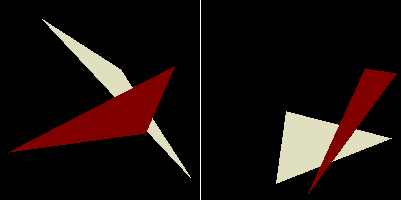

In [13]:
np.random.seed(18)
labels_ = [dummy_triangles(H, classes) for b in range(B)]
labels = np.stack(map(np.array, labels_)).astype(np.uint8)
pil_grid(labels_, 5, margin=1)

### Features

In [14]:
np.random.seed(57)
feats = np.zeros(labels.shape)
feats[labels == 0] = np.random.normal(-1, 2.5, size=feats.shape)[labels == 0]
feats[labels == 1] = np.random.normal(1, 2.5, size=feats.shape)[labels == 1]
feats[labels == 255] = np.random.normal(0, 5, size=feats.shape)[labels == 255]

In [15]:
sess = tf.InteractiveSession()

In [16]:
labels_tf = tf.placeholder(np.int64, shape=(None, H, W), name='labels')
feats_tf = tf.placeholder(np.float32, shape=(None, H, W), name='features')

In [17]:
feed_dict = {labels_tf: labels, 
             feats_tf: feats}

### Model

In [18]:
class Model:
    '''
    Simple linear model
    '''
    
    def __init__(self, feats):
        self.feats = feats
        self.scores
        self.predict

    @define_scope
    def scores(self):
        x = self.feats
        bias = tf.Variable(0., x.dtype, name="bias")
        return tf.add(x, bias, name="scores")
    
    @define_scope
    def probas(self):
        return tf.nn.sigmoid(self.scores)
    
    @define_scope
    def predict(self):
        return tf.greater_equal(self.scores, 0, name="predict")

In [19]:
m = Model(feats_tf)

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
sess.run(tf.global_variables_initializer())

## Lovász-Hinge value

In [22]:
loss = lovasz_hinge(m.scores, labels_tf, ignore=IGNORE, per_image=True)

In [23]:
loss.eval(feed_dict)

3.4664207

#### Gradient w.r.t. bias

In [24]:
tf.gradients(loss, tf.trainable_variables()[0])[0].eval(feed_dict)

Instructions for updating:
Use tf.cast instead.


0.57314444

### PyTorch reference

In [43]:
list(labels[1])

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0

should give the same results...

In [36]:
sess.run(m.probas, feed_dict = feed_dict)

array([[[0.2095516 , 0.18218476, 0.00534987, ..., 0.00716034,
         0.975894  , 0.08838651],
        [0.7827964 , 0.33092624, 0.90648186, ..., 0.01016346,
         0.7740898 , 0.2961551 ],
        [0.05184522, 0.00531888, 0.02090132, ..., 0.8789979 ,
         0.38050306, 0.58989805],
        ...,
        [0.1886994 , 0.00698167, 0.72766674, ..., 0.10598662,
         0.76991826, 0.40220806],
        [0.00163677, 0.04456186, 0.09378377, ..., 0.88229126,
         0.6783152 , 0.70413184],
        [0.9636179 , 0.20051879, 0.354455  , ..., 0.02516502,
         0.06923056, 0.10812038]],

       [[0.4375484 , 0.63856345, 0.12911338, ..., 0.45434463,
         0.00183299, 0.7399399 ],
        [0.6290103 , 0.11815172, 0.585004  , ..., 0.35977268,
         0.02144682, 0.70882356],
        [0.6380924 , 0.29941046, 0.07872403, ..., 0.89736676,
         0.71184397, 0.13168886],
        ...,
        [0.07050583, 0.58764386, 0.70007217, ..., 0.8889915 ,
         0.50423473, 0.53512466],
        [0.0

In [32]:
#[-1, 200, 200]
#[-1, 200,2 00]

<tf.Tensor 'labels:0' shape=(?, 200, 200) dtype=int64>

## Lovász-Sigmoid value

In [26]:
loss = lovasz_softmax(m.probas, labels_tf, classes=[1], ignore=IGNORE, per_image=True)

In [27]:
loss.eval(feed_dict)

0.80367076

In [28]:
tf.gradients(loss, tf.trainable_variables()[0])[0].eval(feed_dict)

0.032584023

### PyTorch reference

In [27]:
sigmoid_out = torch.sigmoid(out)

In [28]:
loss_torch = L_pytorch.lovasz_softmax(sigmoid_out, torch.from_numpy(labels), classes=[1], ignore=IGNORE, per_image=True)
loss_torch

tensor(0.8037, grad_fn=<DivBackward0>)

In [29]:
m_torch.bias.grad.data.fill_(0)
loss_torch.backward()

In [30]:
m_torch.bias.grad.data.numpy().item()

0.03258401155471802